### End-to-End Wireless Communication System Simulation

In [183]:
import numpy as np
import matplotlib.pyplot as plt

In [184]:
MESSAGE = "In a simulated wireless environment, each transmitted symbol experiences random fading due to multipath propagation and Doppler shifts. The channel coefficients are modeled as complex Gaussian variables, ensuring unit average power for consistency across trials. Additive white Gaussian noise is introduced to emulate thermal noise, while Rayleigh fading captures the stochastic nature of urban mobility. By varying the number of samples and seed values, the simulation produces diverse realizations of the wireless channel, allowing robust performance evaluation of modulation schemes under realistic propagation conditions"

TYPE = "text"
PILOT_MESSAGE_BITS = np.array([[0,0],[0,1],[1,0],[1,1],[1,1]])

if TYPE == "text":
    ascii_msg = [ord(c) for c in MESSAGE]
    binary_msg = []
    for asc in ascii_msg:
        binary_str = format(asc,'08b')
        binary_msg.append([int(b) for b in binary_str])

message_bits = np.array([b for block in binary_msg for b in block])
print("\nOriginal message bits sequence\n")
print(message_bits)


Original message bits sequence

[0 1 0 ... 0 1 1]


In [185]:
#QPSK Modulation
def qpsk_modulation(message_bits):
    pairs = message_bits.reshape(-1,2)

    qpsk_mapping = {
        (0,0): 1+1j,
        (1,0): -1+1j,
        (1,1): -1-1j,
        (0,1): 1-1j
    }

    symbols = np.array([qpsk_mapping[tuple(b)] for b in pairs])
    symbols /= np.sqrt(2)
    return symbols

In [186]:
# Wireless channel modelling
def add_awgn(symbols, snr_db):
    snr_linear = pow(10,snr_db/10)
    noise_variance = 1/snr_linear
    noise_sd = np.sqrt(noise_variance/2)

    noise = np.random.normal(0,noise_sd,symbols.shape) + 1j * np.random.normal(0,noise_sd,symbols.shape)

    return symbols+noise

def add_rayleigh_fading(symbols):
    #complex fading coeffs h follows normal dist with mean 0 and variance 1/2
    h = (np.random.randn() + 1j*np.random.randn())/np.sqrt(2)

    return symbols * h, h

def add_frequency_selective_fading(symbols, n_taps = 4):
    gains= (np.random.randn(n_taps) + 1j*np.random.randn(n_taps))/np.sqrt(2)
    delays = [0,1,2,3]
    h = np.zeros(delays[-1] + 1, dtype=complex)

    for d,g in zip(delays,gains):
        h[d] = g
    
    return np.convolve(symbols, h, "full")[:len(symbols)], h

def add_fading(symbols, f_type, n_taps=4):
    if f_type == "FLAT_FADING":
        return add_rayleigh_fading(symbols)
    elif f_type == "FREQUENCY_SELECTIVE":
        return add_frequency_selective_fading(symbols, n_taps)


In [187]:
#Equalizers
def zero_forcing_eq(symbols,h,n_taps=3):
    n_h = len(h)
    H = []
    L_out = n_h + n_taps - 1
    for i in range(n_h + n_taps - 1):
        row = []
        for k in range(n_taps):
            if 0 <= i - k < n_h:
                row.append(h[i - k])
            else:
                row.append(0)
        H.append(row)

    H = np.array(H)

    d = np.zeros(L_out, dtype=complex)
    delay = (n_h + n_taps -1 )//2
    d[delay] = 1 

    w,_,_,_ = np.linalg.lstsq(H,d,rcond=None)

    eq_full = np.convolve(symbols, w, mode="full")

    if delay + len(symbols) <= len(eq_full):
        eq = eq_full[delay : delay + len(symbols)]
    else:
        eq = eq_full[delay:]
    return eq

In [188]:
#QPSK demodulation
def qpsk_demodulation(modulated_symbols):
    message = np.array([])

    for s in modulated_symbols:
        b1 = 0 if s.real >=0 else 1
        b2 = 0 if s.imag >=0 else 1
        message = np.append(message,[b1,b2])
    return message

In [189]:
def calc_BER(tx,rx):
    mismatches = np.sum(tx != rx)

    ber = mismatches / len(tx)

    return ber, mismatches

Number of bits transmitted: 4992

For SNR = 0 dB,  Mismatches: 575, BER = 0.11518429487179487
For SNR = 10 dB,  Mismatches: 64, BER = 0.01282051282051282
For SNR = 20 dB,  Mismatches: 44, BER = 0.008814102564102564
For SNR = 30 dB,  Mismatches: 46, BER = 0.00921474358974359
For SNR = 40 dB,  Mismatches: 35, BER = 0.007011217948717949


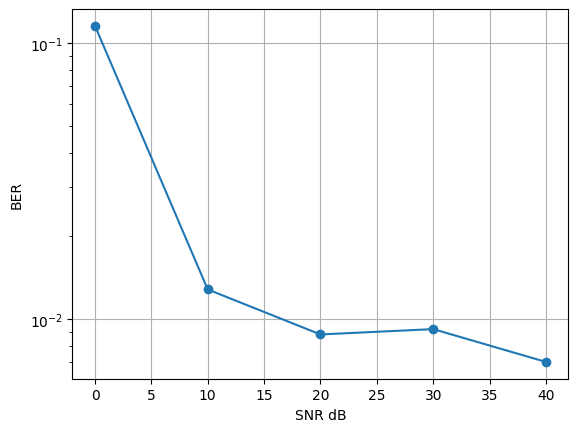

In [190]:
# Overall Pipeine

#Modulation
symbols = qpsk_modulation(message_bits=message_bits)
pilot_symbols = qpsk_modulation(PILOT_MESSAGE_BITS)
n_pilot_symbols = len(pilot_symbols)

print(f"Number of bits transmitted: {len(symbols)*2}\n")
snr = range(0,50,10)

block_size = 100
ber_values = []

for s in snr:
    eq=[] #equalized symbols

    num_blocks = int(np.ceil(len(symbols)/block_size))

    for i in range(num_blocks):
        start = i*block_size
        end = min((i+1)*block_size, len(symbols))
        data_block = symbols[start:end]
        tx_symbols = np.concatenate((pilot_symbols,data_block))

        rx_symbols,h = add_fading(tx_symbols, f_type="FREQUENCY_SELECTIVE", n_taps=4) # flat or freqeuency selective
        rx_symbols= add_awgn(symbols=rx_symbols, snr_db=s) #noise at different snr level

        #Channel estimation
        rx_pilot_symbols = rx_symbols[:n_pilot_symbols]
        rx_message_symbols = rx_symbols[n_pilot_symbols:]

        # num = np.dot(np.conj(pilot_symbols), rx_pilot_symbols)
        # den = np.dot(np.conj(pilot_symbols), pilot_symbols)
        # h_est = num/den

        #equalization using zero forcing
        eq_block = zero_forcing_eq(rx_message_symbols,h,n_taps=10)
        eq.extend(eq_block)

    eq = np.array(eq)

    demod_bits = qpsk_demodulation(eq)

    ber_value, mismatch_counts = calc_BER(message_bits, demod_bits)
    ber_values.append(ber_value)
    print(f"For SNR = {s} dB,  Mismatches: {mismatch_counts}, BER = {ber_value}")
    

plt.semilogy(list(snr), ber_values, marker='o')
plt.xlabel('SNR dB')
plt.ylabel('BER')
plt.grid(True)
plt.show()